In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Library which will allow us to do simple linear regression
from scipy.stats import linregress

# Library which allows plotting of a world map
from mpl_toolkits.basemap import Basemap

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Input File (CSV)
input_data_file = "output_data/cities.csv"

In [2]:
# Read the previously created weather data from a file
clean_city_data = pd.read_csv(input_data_file)

In [3]:
clean_city_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1321 entries, 0 to 1320
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   1321 non-null   int64  
 1   City         1321 non-null   object 
 2   Latitude     1321 non-null   float64
 3   Longitude    1321 non-null   float64
 4   Max Temp     1321 non-null   float64
 5   Wind Speed   1321 non-null   float64
 6   Cloudiness   1321 non-null   float64
 7   Description  1321 non-null   object 
 8   Humidity     1321 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 93.0+ KB


In [4]:
# Cleaning of the data - first pass
#
# We need to remove any "duplicate entries" from the data, if we are going to generate a heatmap
# Problems arise if we have two cities that have exactly the same longitude.  To get around this, we
# can create a "fake" longitude, which is extremely close to the original longitude, but is just augmented
# slightly by the addition of a term proportional to the latitude.  This should result in different values of
# augmented longitude for each city in the dataframe.
clean_city_data['Augmented Longitude']=clean_city_data['Longitude']+0.0001*clean_city_data['Latitude']

# Sort the dataframe based upon this new augmented longitude.
clean_city_data.sort_values("Augmented Longitude", inplace = True)

# Drop any duplicate entries that might remain.  Note that in this example we went from 1321 entries in the 
# original dataframe to 1319 entries in the new dataframe.
clean_city_data.drop_duplicates(subset ="Augmented Longitude",keep = False, inplace = True)

clean_city_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 361 to 976
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           1319 non-null   int64  
 1   City                 1319 non-null   object 
 2   Latitude             1319 non-null   float64
 3   Longitude            1319 non-null   float64
 4   Max Temp             1319 non-null   float64
 5   Wind Speed           1319 non-null   float64
 6   Cloudiness           1319 non-null   float64
 7   Description          1319 non-null   object 
 8   Humidity             1319 non-null   float64
 9   Augmented Longitude  1319 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 113.4+ KB


In [5]:
# Cleaning of the data - second pass
#
# create a new dataframe, called parsed_data, which includes only those cities that have
# a) a temperature above 70F
# b) a temperature below 80F
# c) a wind speed < 10 mph
# d) a cloudiness = 0
#
parsed_data = clean_city_data[clean_city_data['Max Temp']>=(70-32.0)*5.0/9.0+273.15]
parsed_data = parsed_data[parsed_data['Max Temp']<=(80-32.0)*5.0/9.0+273.15]
parsed_data = parsed_data[parsed_data['Wind Speed']<=10]
parsed_data = parsed_data[parsed_data['Cloudiness']==0]

parsed_data

,Unnamed: 0,City,Latitude,Longitude,Max Temp,Wind Speed,Cloudiness,Description,Humidity,Augmented Longitude
1271,1271,monte patria,-30.6919,-70.9467,298.71,1.09,0.0,clear sky,10.0,-70.949769
978,978,santiago,-33.4569,-70.6483,295.37,1.22,0.0,clear sky,40.0,-70.651646
629,629,nouadhibou,20.9310,-17.0347,298.15,7.72,0.0,clear sky,53.0,-17.032607
350,350,casablanca,33.5928,-7.6192,298.15,7.72,0.0,clear sky,73.0,-7.615841
974,974,santa pola,38.1917,-0.5658,297.04,2.06,0.0,clear sky,64.0,-0.561981
517,517,capoterra,39.1763,8.9718,296.15,4.12,0.0,clear sky,64.0,8.975718
1278,1278,siniscola,40.5719,9.6922,295.15,3.60,0.0,clear sky,49.0,9.696257
1229,1229,walvis bay,-22.9575,14.5053,295.15,3.60,0.0,clear sky,53.0,14.503004
959,959,klos,41.5072,20.0851,295.15,0.51,0.0,clear sky,56.0,20.089251
89,89,marsa matruh,31.3525,27.2453,297.15,5.14,0.0,clear sky,73.0,27.248435


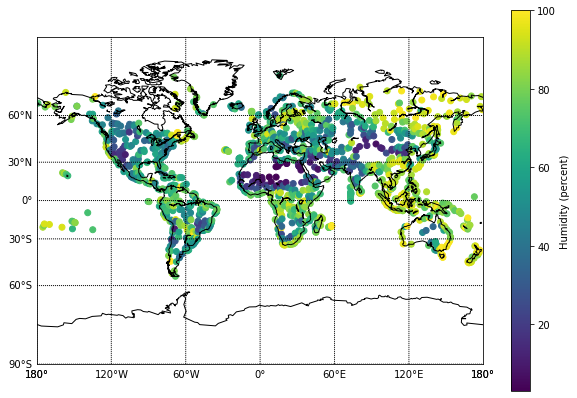

In [6]:
# Create a heatmap of the original dataframe.  We are using here the Basemap library from the mpl_toolkits module.

plt.subplots(figsize=(10, 7))

map = Basemap(projection='mill',lon_0=0)
# plot coastlines, draw label meridians and parallels.
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])

map.scatter(clean_city_data['Longitude'], clean_city_data['Latitude'], latlon=True, 
            c=clean_city_data['Humidity'])

plt.colorbar(label=r'Humidity (percent)')

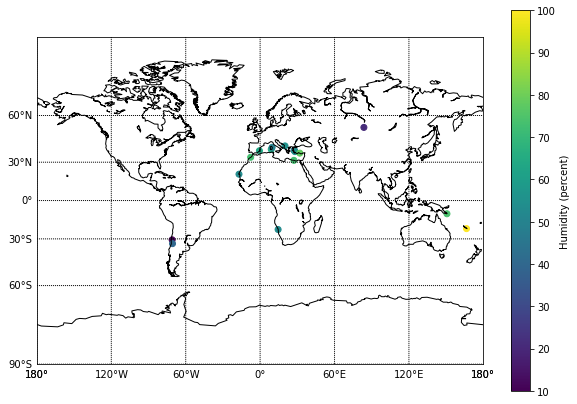

In [7]:
# create a heatmap of the parsed data
plt.subplots(figsize=(10, 7))

map = Basemap(projection='mill',lon_0=0)
# plot coastlines, draw label meridians and parallels.
map.drawcoastlines()
map.drawparallels(np.arange(-90,90,30),labels=[1,0,0,0])
map.drawmeridians(np.arange(map.lonmin,map.lonmax+30,60),labels=[0,0,0,1])

map.scatter(parsed_data['Longitude'], parsed_data['Latitude'], latlon=True, 
            c=parsed_data['Humidity'])

plt.colorbar(label=r'Humidity (percent)')

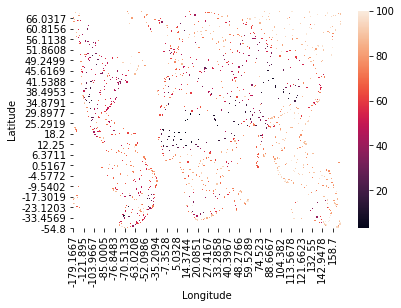

In [8]:
import seaborn as sns

cleaned_data_plotting = clean_city_data.pivot("Latitude", "Longitude", "Humidity")

ax = sns.heatmap(cleaned_data_plotting)
ax.invert_yaxis()

In [10]:
!jupyter nbextension enable --py gmaps
!jupyter nbextension enable --py widgetsnbextension
import gmaps
import gmaps.datasets

locations = clean_city_data[['Latitude', 'Longitude']]
weights = clean_city_data['Humidity']

fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locations, weights=weights))
fig

Enabling notebook extension jupyter-gmaps/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Figure(layout=FigureLayout(height='420px'))